In [3]:
import numpy as np 

In [4]:
image=np.load('/content/drive/MyDrive/Brain_tumor_Segmentation/asad data/data/combined data final folder/flair/mri.npy')

In [5]:
masks=np.load('/content/drive/MyDrive/Brain_tumor_Segmentation/asad data/data/combined data final folder/flair/masks.npy')


In [6]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Activation, Reshape, Dense
from keras.layers.convolutional import Convolution2D
from keras.layers import BatchNormalization
#from keras import layers
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [7]:
image.shape,masks.shape

((31936, 128, 128, 1), (31936, 128, 128, 4))

In [8]:
masks=np.argmax(masks,axis=3)


In [9]:
masks.shape

(31936, 128, 128)

In [10]:
x_train, x_val, y_train, y_val = train_test_split(image, masks, test_size = 0.2)

In [11]:
del image
del masks

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.20)

In [13]:
x_train.shape,y_train.shape

((20438, 128, 128, 1), (20438, 128, 128))

In [14]:

def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def dice_coef(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))


In [15]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Activation, Reshape, Dense
from keras.layers.convolutional import Convolution2D
from keras.layers import BatchNormalization

#from layers import MaxPoolingWithArgmax2D, MaxUnpooling2D

def segnet(
        input_shape,
        n_labels,
        kernel=3,
        pool_size=(2, 2),
        output_mode="softmax"):
    # encoder
    inputs = Input(shape=input_shape)
    #inputs = tf.convert_to_tensor(inputs)
    conv_1 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block1_conv1")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block1_conv2")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)
    pool_1 = MaxPooling2D(pool_size, name="block1_pool")(conv_2)

    conv_3 = Convolution2D(128, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block2_conv1")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(128, (kernel, kernel), padding="same", kernel_initializer='he_normal',  name="block2_conv2")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2 = MaxPooling2D(pool_size, name="block2_pool")(conv_4)

    conv_5 = Convolution2D(256, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block3_conv1")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(256, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block3_conv2")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Convolution2D(256, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block3_conv3")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)

    pool_3 = MaxPooling2D(pool_size, name="block3_pool")(conv_7)

    conv_8 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block4_conv1")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block4_conv2")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block4_conv3")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)

    pool_4 = MaxPooling2D(pool_size, name="block4_pool")(conv_10)

    conv_11 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block5_conv1")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal',  name="block5_conv2")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal',  name="block5_conv3")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)

    pool_5 = MaxPooling2D(pool_size, name="block5_pool")(conv_13)
   
    # decoder
    unpool_1 = UpSampling2D(pool_size)(pool_5)

    conv_14 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)

    unpool_2 = UpSampling2D(pool_size)(conv_16)

    conv_17 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Convolution2D(256, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = UpSampling2D(pool_size)(conv_19)

    conv_20 = Convolution2D(256, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Convolution2D(256, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Convolution2D(128, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)

    unpool_4 = UpSampling2D(pool_size)(conv_22)

    conv_23 = Convolution2D(128, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    unpool_5 = UpSampling2D(pool_size)(conv_24)
    #pool, ind, output_shape, batch_size, name=None

    conv_25 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Convolution2D(n_labels, (1, 1), padding="same", kernel_initializer='he_normal')(conv_25)
    conv_26 = BatchNormalization()(conv_26)

    conv_26 = Reshape((128,128,4))(conv_26)
    #conv_26 = Dense(4)(conv_26)
    outputs = Activation(output_mode)(conv_26)
    print("Build decoder done..")
    #pred = Reshape((128,128,128))(outputs)
    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model


model = segnet(input_shape=(128,128,1), n_labels=4)

model.summary()
print(model.input_shape)
print(model.output_shape)

Build decoder done..
Model: "SegNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                       

In [16]:
model.compile(optimizer= Adam(learning_rate=0.0001), loss= ["categorical_crossentropy"]
                  , metrics=['acc'])


In [17]:
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

In [18]:
y_train.shape

(20438, 128, 128, 4)

In [24]:
path_model='/content/drive/MyDrive/Brain_tumor_Segmentation/asad data/results/final Results all modility/results/complete results/flair for generated data/model/'

In [20]:
path_data='/content/drive/MyDrive/Brain_tumor_Segmentation/asad data/results/final Results all modility/results/complete results/flair for generated data/'

In [21]:
np.save(path_data+'y_test',y_test)
np.save(path_data+'x_test',x_test)

In [22]:
hist = model.fit(x_train, y_train, epochs= 40, batch_size= 10, validation_data= (x_val, y_val), verbose=1)

Epoch 1/40
2044/2044 [==============================] - 185s 84ms/step - loss: 1.0212 - acc: 0.9386 - val_loss: 0.9155 - val_acc: 0.9563
Epoch 2/40
2044/2044 [==============================] - 168s 82ms/step - loss: 0.7562 - acc: 0.9662 - val_loss: 0.6343 - val_acc: 0.9690
Epoch 3/40
2044/2044 [==============================] - 169s 82ms/step - loss: 0.5639 - acc: 0.9726 - val_loss: 0.4668 - val_acc: 0.9774
Epoch 4/40
2044/2044 [==============================] - 168s 82ms/step - loss: 0.4142 - acc: 0.9773 - val_loss: 0.4081 - val_acc: 0.9684
Epoch 5/40
2044/2044 [==============================] - 169s 83ms/step - loss: 0.3067 - acc: 0.9797 - val_loss: 0.2497 - val_acc: 0.9825
Epoch 6/40
2044/2044 [==============================] - 168s 82ms/step - loss: 0.2287 - acc: 0.9818 - val_loss: 0.1913 - val_acc: 0.9824
Epoch 7/40
2044/2044 [==============================] - 169s 83ms/step - loss: 0.1684 - acc: 0.9840 - val_loss: 0.1434 - val_acc: 0.9848
Epoch 8/40
2044/2044 [===================

In [27]:
model.save(path_model)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Brain_tumor_Segmentation/asad data/results/final Results all modility/results/complete results/flair for generated data/model/assets


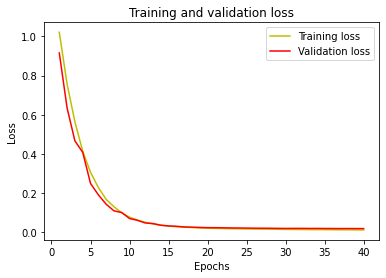

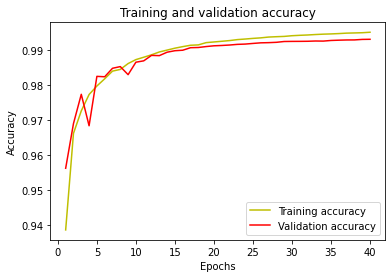

In [26]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = hist.history['acc']
val_acc = hist.history['val_acc']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
prediction = model.predict(x_test)
prediction.shape

(5110, 128, 128, 4)

In [30]:
acc=accuracy(y_test,prediction)
acc

<tf.Tensor: shape=(), dtype=float32, numpy=0.9965256>

In [31]:
pred=np.argmax(prediction, axis=3)

In [32]:
y_test_max=np.argmax(y_test, axis=3)

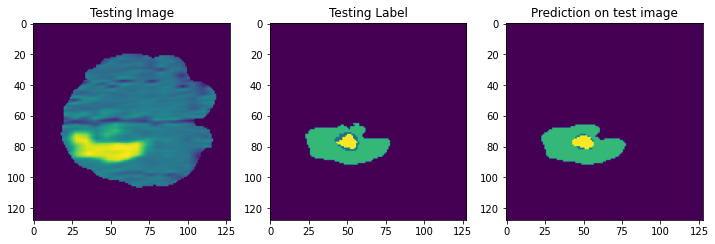

In [43]:
import random
image = random.randint(0,2688)

plt.figure(figsize=(12, 8))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(x_test[image,:,:,0])
plt.subplot(132)
plt.title('Testing Label')
plt.imshow(y_test_max[image])
plt.subplot(133)
plt.title('Prediction on test image')
plt.imshow(pred[image])
plt.show()

In [37]:
from sklearn.metrics import jaccard_score
iou=jaccard_score(y_test_max[:,:,:].flatten(),pred[:,:,:].flatten(),average=None)
iou

array([0.99532196, 0.82911705, 0.84238393, 0.77430015])

In [38]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [39]:
s=iou(y_test_max.flatten(),pred.flatten())


In [40]:
s

<tf.Tensor: shape=(), dtype=float64, numpy=0.8855086877914448>

In [ ]:
aa=accuracy(y_test_max,pred)
aa

In [ ]:
accuracy_matric=accuracy(y_test_max,pred)

In [ ]:
accuracy_matric